# INL - Recognizing temporal expressions

## Loading and visualising

In [71]:
import pandas
import csv
columns = ['ORDER_ID','TOKEN_ID','ORTH','LEMMA','POS','CTAG','LABEL']
test_raw = pandas.read_csv('kpwr-time_TEST.txt',index_col=False, sep = '\t', names=columns, quoting=csv.QUOTE_NONE, keep_default_na = False)
train_raw = pandas.read_csv('kpwr-time_TRAIN.txt',index_col=False, sep = '\t', names=columns, quoting=csv.QUOTE_NONE, keep_default_na = False)
print(f'Sample row : \n{train_raw.iloc[0]}')

Sample row : 
ORDER_ID                 0
TOKEN_ID                 0
ORTH             RoboRally
LEMMA            roborally
POS                  subst
CTAG        subst:sg:nom:n
LABEL                    O
Name: 0, dtype: object


Checking the datasets for any null values

In [72]:
print(f'Count before dropping nulls : train - {train_raw.shape[0]}, test - {test_raw.shape[0]}')
train_raw = train_raw.dropna()
test_raw = test_raw.dropna()
print(f'Count after dropping nulls : train - {train_raw.shape[0]}, test - {test_raw.shape[0]}')

Count before dropping nulls : train - 363366, test - 87032
Count after dropping nulls : train - 363366, test - 87032


Helper function to visualise labels split in the dataset

In [73]:
import matplotlib.pyplot as plt
import random
def plot_labels(dataset): 
    labels = {}
    for label in dataset['LABEL'].unique():
        labels[label] = dataset[dataset['LABEL'] == label].count() / dataset.count()
        labels[label] = labels[label][0]

    labels_values = list(labels.values())
    labels_names = list(labels.keys())
    colors_ = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
    colors = colors_(len(labels))

    fig, ax = plt.subplots(figsize=[5, 5], facecolor=(1, 1, 1))
    patches, texts = ax.pie(labels_values, colors=colors)

    my_circle=plt.Circle( (0,0), 0.4, color='white')
    fig.gca().add_artist(my_circle)
    plt.legend(patches,labels_names, loc="lower left")
    plt.axis('equal')
    plt.tight_layout()
    sub_axes =  ax.inset_axes([0.9, .3, 0.6, 0.6]) 
    sub_axes.pie(labels_values[1:], colors= colors[1:])
    plt.arrow(0.8,0,0.5,0.2, width = 0.04)
    plt.title('Split of label tags in the dataset')
    plt.show()


Split in the training sets. We can see that the datasets are heavily skewed towards non-temporal tags.

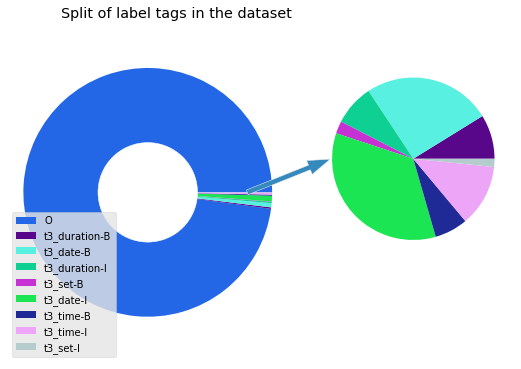

In [74]:
plot_labels(train_raw)

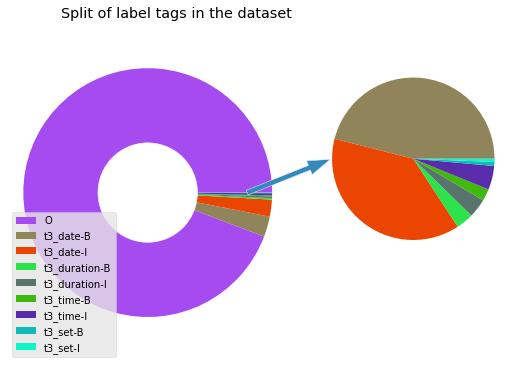

In [75]:
plot_labels(test_raw)

In [76]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Preprocessing

First we define the columns that we want to tokenize and cast them to string values

In [77]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np

tokenizable_columns = ['ORTH','LEMMA','POS','CTAG','LABEL']
for column in tokenizable_columns:
    train_raw[column] = train_raw[column].astype(str)
    test_raw[column] = test_raw[column].astype(str)

We change all semicolons to special tag so that we can split on semicolons automatically while tagging in the CTAG column

In [78]:
for column in ['ORTH','LEMMA','POS','LABEL']:
    train_raw[column] = train_raw[column].replace(':','XX_SEMICOLON_XX')
    test_raw[column] = test_raw[column].replace(':','XX_SEMICOLON_XX')

We create tokenizer for each column and run it on the values

In [79]:
train = train_raw.copy()
test = test_raw.copy()
for column in tokenizable_columns:
    token_list = train_raw[column].values.tolist()
    token_list.extend(test_raw[column].values.tolist())
    token_count = len(train_raw[column].unique()) + len(test_raw[column].unique()) + 1
    tokenizer = Tokenizer(num_words=token_count, filters = '')#, split=':')
    tokenizer.fit_on_texts(token_list)
    train[column] = tokenizer.texts_to_sequences(train_raw[column])
    test[column] = tokenizer.texts_to_sequences(test_raw[column])

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(train.iloc[0:7])
print(test.iloc[0:7])

   ORDER_ID  TOKEN_ID     ORTH    LEMMA   POS  CTAG LABEL
0         0         0  [28849]  [16624]   [1]  [22]   [1]
1         1         1     [41]     [51]   [6]   [2]   [1]
2         2         2   [2329]    [117]   [3]  [41]   [1]
3         3         3   [2068]   [1267]   [1]  [22]   [1]
4         4         4     [21]     [26]   [2]   [1]   [1]
5         5         0    [345]    [500]  [15]  [20]   [1]
6         6         1      [9]     [10]   [6]   [2]   [1]
   ORDER_ID  TOKEN_ID     ORTH    LEMMA  POS  CTAG LABEL
0    363366         0      [6]      [7]  [4]  [16]   [1]
1    363367         1    [310]    [200]  [1]  [34]   [1]
2    363368         2     [17]     [20]  [4]  [16]   [1]
3    363369         3     [13]     [13]  [1]  [34]   [1]
4    363370         4    [664]    [230]  [1]  [34]   [1]
5    363371         5  [57279]  [12814]  [1]   [9]   [1]
6    363372         6     [23]     [28]  [1]   [4]   [1]


We pad the ctag columns so that they are all the same length

In [80]:
from keras.preprocessing.sequence import pad_sequences

train_columns = ['ORDER_ID','TOKEN_ID','ORTH','LEMMA','POS','CTAG','LABEL']

x_train = train.copy()[train_columns]
x_test = test.copy()[train_columns]

# ctag_count = len(max(train['CTAG'],key=len)) 

# x_train['CTAG'] = pandas.Series(pad_sequences(train['CTAG'],padding='post',  maxlen=ctag_count).tolist())
# x_test['CTAG'] = pandas.Series(pad_sequences(test['CTAG'],padding='post',  maxlen=ctag_count).tolist())

Cast the columns with single-item lists to those items

In [81]:
for c in ['ORTH','LEMMA','POS','LABEL', 'CTAG']:
    x_train[c] =  x_train[c].apply(lambda a : a[0] if isinstance(a,list) else a)
    x_test[c] =  x_test[c].apply(lambda a : a[0] if isinstance(a,list) else a)

In [82]:
print(x_train[0:5])
print(x_test[0:5])

   ORDER_ID   ORTH  LEMMA  POS  CTAG  LABEL
0         0  28849  16624    1    22      1
1         1     41     51    6     2      1
2         2   2329    117    3    41      1
3         3   2068   1267    1    22      1
4         4     21     26    2     1      1
   ORDER_ID  ORTH  LEMMA  POS  CTAG  LABEL
0    363366     6      7    4    16      1
1    363367   310    200    1    34      1
2    363368    17     20    4    16      1
3    363369    13     13    1    34      1
4    363370   664    230    1    34      1


Dropping any possible na values in the dataset

In [83]:
x_train.dropna(inplace=True)
x_test.dropna(inplace=True)
x_train

,ORDER_ID,ORTH,LEMMA,POS,CTAG,LABEL
0,0,28849,16624,1,22,1
1,1,41,51,6,2,1
2,2,2329,117,3,41,1
3,3,2068,1267,1,22,1
4,4,21,26,2,1,1
...,...,...,...,...,...,...
363361,363361,9750,344,5,76,1
363362,363362,3,3,4,5,1
363363,363363,186,11,16,301,1
363364,363364,1187,194,1,6,1


Split CTAG column into multiple and drop columns that are meaningless for us

In [84]:
# ctag_cols = [f'CTAG_{i}' for i in range(0,ctag_count)]
# ctag_split = pandas.DataFrame(x_train['CTAG'].to_list(), columns = ctag_cols)

In [85]:
cols_to_drop = ['LABEL']
x_train_split = x_train
y_train = x_train_split['LABEL']
x_train_split.drop(columns = cols_to_drop, inplace = True)
x_train_split

,ORDER_ID,ORTH,LEMMA,POS,CTAG
0,0,28849,16624,1,22
1,1,41,51,6,2
2,2,2329,117,3,41
3,3,2068,1267,1,22
4,4,21,26,2,1
...,...,...,...,...,...
363361,363361,9750,344,5,76
363362,363362,3,3,4,5
363363,363363,186,11,16,301
363364,363364,1187,194,1,6


## First idea of a naive neural network

In [105]:
# ctag_split_test = pandas.DataFrame(x_test['CTAG'].to_list(), columns = ctag_cols)
# x_test_split = x_test.join(ctag_split_test, how = 'inner')
# x_test_split.dropna(inplace=True)
# y_test = x_test_split['LABEL']
# x_test_split.drop(columns = cols_to_drop, inplace = True)
# x_test_split

,ORTH,LEMMA,POS,CTAG_0,CTAG_1,CTAG_2,CTAG_3,CTAG_4,CTAG_5
0,6,7,4,11,14,0,0,0,0
1,310,200,1,2,1,14,13,0,0
2,17,20,4,11,14,0,0,0,0
3,13,13,1,2,1,14,13,0,0
4,664,230,1,2,1,14,13,0,0
...,...,...,...,...,...,...,...,...,...
87027,2,2,2,4,0,0,0,0,0
87028,27,34,7,23,0,0,0,0,0
87029,65093,16623,3,10,1,14,5,9,0
87030,1950,766,1,2,1,14,5,0,0


In [106]:
# final_cols = train_columns + ctag_cols
# for c in cols_to_drop:
#     final_cols.remove(c)
# x_train_stacked = np.vstack(x_train_split[final_cols].values)
# x_train_stacked

array([[28849, 16624,     1, ...,    13,     0,     0],
       [   41,    51,     6, ...,     0,     0,     0],
       [ 2329,   117,     3, ...,    13,     9,     0],
       ...,
       [  186,    11,    16, ...,    19,    37,    55],
       [ 1187,   194,     1, ...,     5,     0,     0],
       [    1,     1,     2, ...,     0,     0,     0]], dtype=int64)

In [107]:
# x_test_stacked = np.vstack(x_test_split[final_cols].values)
# x_test_stacked

array([[    6,     7,     4, ...,     0,     0,     0],
       [  310,   200,     1, ...,    13,     0,     0],
       [   17,    20,     4, ...,     0,     0,     0],
       ...,
       [65093, 16623,     3, ...,     5,     9,     0],
       [ 1950,   766,     1, ...,     5,     0,     0],
       [    1,     1,     2, ...,     0,     0,     0]], dtype=int64)

In [108]:
y_train =  y_train.apply(lambda a : a[0] if isinstance(a,list) else a)
y_test =  y_test.apply(lambda a : a[0] if isinstance(a,list) else a)

In [109]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder  = OneHotEncoder(sparse=False)
y_train_encoded = onehot_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = onehot_encoder.fit_transform(y_test.values.reshape(-1, 1))
print(y_test_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [110]:
from keras.models import Sequential
from keras import layers

input_dim = x_train_stacked.shape[1]

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(9, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                100       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 9)                 99        
                                                                 
Total params: 419
Trainable params: 419
Non-trainable params: 0
_________________________________________________________________


In [111]:
from keras.backend import clear_session
clear_session()
history = model.fit(x_train_stacked, y_train_encoded,
                    epochs=10,
                    # verbose=False,
                    validation_data=(x_test_stacked, y_test_encoded),
                    batch_size=50)

Epoch 1/10
7268/7268 [==============================] - 5s 709us/step - loss: 8.7580 - accuracy: 0.9625 - val_loss: 0.5148 - val_accuracy: 0.9425
Epoch 2/10
7268/7268 [==============================] - 5s 695us/step - loss: 0.1722 - accuracy: 0.9791 - val_loss: 0.3192 - val_accuracy: 0.9413
Epoch 3/10
7268/7268 [==============================] - 5s 697us/step - loss: 0.1276 - accuracy: 0.9799 - val_loss: 0.3046 - val_accuracy: 0.9435
Epoch 4/10
7268/7268 [==============================] - 5s 696us/step - loss: 0.1252 - accuracy: 0.9799 - val_loss: 0.3020 - val_accuracy: 0.9435
Epoch 5/10
7268/7268 [==============================] - 5s 679us/step - loss: 0.1239 - accuracy: 0.9799 - val_loss: 0.3069 - val_accuracy: 0.9435
Epoch 6/10
7268/7268 [==============================] - 5s 702us/step - loss: 0.1248 - accuracy: 0.9799 - val_loss: 0.3009 - val_accuracy: 0.9435
Epoch 7/10
7268/7268 [==============================] - 5s 726us/step - loss: 0.1239 - accuracy: 0.9799 - val_loss: 0.3059 -

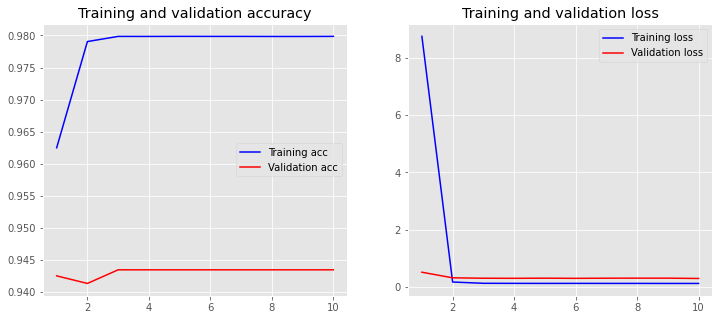

In [112]:
plot_history(history)

In [113]:
from keras.models import Sequential
from keras import layers


model = Sequential()
model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(9, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1000      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 9)                 909       
                                                                 
Total params: 22,109
Trainable params: 22,109
Non-trainable params: 0
_________________________________________________________________


In [114]:
from keras.backend import clear_session
clear_session()
history = model.fit(x_train_stacked, y_train_encoded,
                    epochs=10,
                    # verbose=False,
                    validation_data=(x_test_stacked, y_test_encoded),
                    batch_size=50)

Epoch 1/10
7268/7268 [==============================] - 7s 929us/step - loss: 1.2174 - accuracy: 0.9774 - val_loss: 0.2928 - val_accuracy: 0.9435
Epoch 2/10
7268/7268 [==============================] - 7s 937us/step - loss: 0.1278 - accuracy: 0.9798 - val_loss: 0.2806 - val_accuracy: 0.9453
Epoch 3/10
7268/7268 [==============================] - 7s 914us/step - loss: 0.1271 - accuracy: 0.9799 - val_loss: 0.2735 - val_accuracy: 0.9444
Epoch 4/10
7268/7268 [==============================] - 7s 903us/step - loss: 0.1259 - accuracy: 0.9799 - val_loss: 0.2877 - val_accuracy: 0.9452
Epoch 5/10
7268/7268 [==============================] - 6s 892us/step - loss: 0.1305 - accuracy: 0.9799 - val_loss: 0.2830 - val_accuracy: 0.9475
Epoch 6/10
7268/7268 [==============================] - 7s 912us/step - loss: 0.1251 - accuracy: 0.9800 - val_loss: 0.2752 - val_accuracy: 0.9475
Epoch 7/10
7268/7268 [==============================] - 7s 916us/step - loss: 0.1221 - accuracy: 0.9800 - val_loss: 0.2677 -

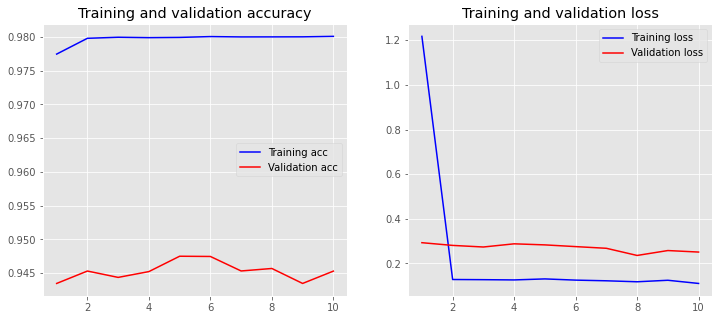

In [115]:
plot_history(history)

In [116]:
x_train_stacked.shape

(363366, 9)

In [117]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, LSTM, Flatten

model = Sequential()
model.add(LSTM(32,input_shape=(None,x_train_stacked.shape[1]), return_sequences = True ))
model.add(LSTM(32,input_shape=(None,16)))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(9))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          5376      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 9)                 153       
                                                                 
Total params: 14,377
Trainable params: 14,377
Non-trainable params: 0
_________________________________________________________________


In [118]:
# x_train_sampled = list()
# length = 200
# for i in range(0,x_train_stacked.shape[0],length):
# 	sample = np.array(x_train_stacked[i:i+length])
# 	x_train_sampled.append(sample)
# x_train_sampled = np.array(x_train_sampled)
# x_train_sampled

In [119]:
x_train_lstm = x_train_stacked.reshape((x_train_stacked.shape[0],1,x_train_stacked.shape[1]))
x_test_lstm = x_test_stacked.reshape((x_test_stacked.shape[0],1,x_test_stacked.shape[1]))
print(x_train_lstm.shape)
print(x_train_lstm)

(363366, 1, 9)
[[[28849 16624     1 ...    13     0     0]]

 [[   41    51     6 ...     0     0     0]]

 [[ 2329   117     3 ...    13     9     0]]

 ...

 [[  186    11    16 ...    19    37    55]]

 [[ 1187   194     1 ...     5     0     0]]

 [[    1     1     2 ...     0     0     0]]]


In [120]:
y_train_lstm = y_train_encoded.reshape(y_train_encoded.shape[0],9)
y_test_lstm = y_test_encoded.reshape(y_test_encoded.shape[0],9)
# y_train_lstm = y_train.values.reshape(y_train.shape[0],1)
# y_test_lstm = y_test.values.reshape(y_test.shape[0],1)
print(y_train_lstm.shape)
print(y_train_lstm)

(363366, 9)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [121]:
from keras.backend import clear_session
clear_session()
history = model.fit(x_train_lstm, y_train_lstm,
                    epochs=10,
                    # verbose=False,
                    validation_data=(x_test_lstm, y_test_lstm),
                    batch_size=50)

Epoch 1/10
7268/7268 [==============================] - 18s 2ms/step - loss: 8.6153 - accuracy: 0.0056 - val_loss: 6.5641 - val_accuracy: 0.0096
Epoch 2/10
7268/7268 [==============================] - 16s 2ms/step - loss: 5.8071 - accuracy: 0.0032 - val_loss: 6.5641 - val_accuracy: 0.0096
Epoch 3/10
7268/7268 [==============================] - 16s 2ms/step - loss: 5.8071 - accuracy: 0.0032 - val_loss: 6.5641 - val_accuracy: 0.0096
Epoch 4/10
7268/7268 [==============================] - 16s 2ms/step - loss: 5.8071 - accuracy: 0.0032 - val_loss: 6.5641 - val_accuracy: 0.0096
Epoch 5/10
7268/7268 [==============================] - 16s 2ms/step - loss: 5.8071 - accuracy: 0.0032 - val_loss: 6.5641 - val_accuracy: 0.0096
Epoch 6/10
7268/7268 [==============================] - 15s 2ms/step - loss: 5.8071 - accuracy: 0.0032 - val_loss: 6.5641 - val_accuracy: 0.0096
Epoch 7/10
7268/7268 [==============================] - 16s 2ms/step - loss: 5.8071 - accuracy: 0.0032 - val_loss: 6.5641 - val_ac

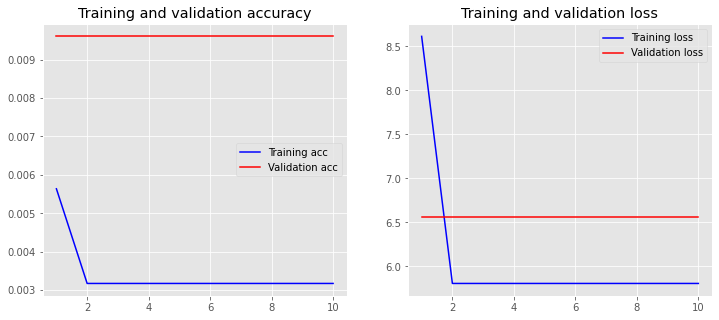

In [122]:
plot_history(history)

In [123]:
model.predict(x_test_lstm)

array([[-0.24204066,  0.15220709,  0.22879314, ...,  0.11011269,
        -0.04220149, -0.20539998],
       [-0.27974895,  0.18108627,  0.29458594, ...,  0.16365026,
        -0.1160436 , -0.2762895 ],
       [-0.28155094,  0.19555962,  0.26168066, ...,  0.15949914,
        -0.07081058, -0.24203098],
       ...,
       [-0.26624197,  0.1931294 ,  0.24665187, ...,  0.07941832,
        -0.11239135, -0.31069055],
       [-0.33314216,  0.2128177 ,  0.29647303, ...,  0.12433164,
        -0.10630131, -0.35720798],
       [-0.19894142,  0.13849573,  0.17009954, ...,  0.13849846,
        -0.05266805, -0.16945001]], dtype=float32)

In [124]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, LSTM, Flatten

model = Sequential()
model.add(layers.Dense(9,input_shape=(None,9), activation='relu'))
model.add(layers.Conv1D(32,kernel_size=1, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(9, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 9)           90        
                                                                 
 conv1d (Conv1D)             (None, None, 32)          320       
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
 dense_2 (Dense)             (None, 9)                 99        
                                                                 
Total params: 839
Trainable params: 839
Non-trainable params: 0
__________________________________________________________

In [125]:
from keras.backend import clear_session
clear_session()
history = model.fit(x_train_lstm, y_train,
                    epochs=10,
                    # verbose=False,
                    validation_data=(x_test_stacked, y_test),
                    batch_size=50)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\kajka\Documents\ProgrammingProjects\PJATK\Sem3\INL\Projekt\pyenv\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\kajka\Documents\ProgrammingProjects\PJATK\Sem3\INL\Projekt\pyenv\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kajka\Documents\ProgrammingProjects\PJATK\Sem3\INL\Projekt\pyenv\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\kajka\Documents\ProgrammingProjects\PJATK\Sem3\INL\Projekt\pyenv\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "c:\Users\kajka\Documents\ProgrammingProjects\PJATK\Sem3\INL\Projekt\pyenv\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\kajka\Documents\ProgrammingProjects\PJATK\Sem3\INL\Projekt\pyenv\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\kajka\Documents\ProgrammingProjects\PJATK\Sem3\INL\Projekt\pyenv\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\kajka\Documents\ProgrammingProjects\PJATK\Sem3\INL\Projekt\pyenv\lib\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\kajka\Documents\ProgrammingProjects\PJATK\Sem3\INL\Projekt\pyenv\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 9) are incompatible


In [ ]:
plot_history(history)